In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import gurobipy as gp
from gurobipy import GRB
import itertools
from itertools import combinations
from itertools import permutations
from random import choice
import json
import copy
import time
import scipy.stats as stats
from scipy.stats import gumbel_r,expon

In [3]:
np.random.seed(1)
random.seed(1)

In [4]:
raw_jd_choice = pd.read_excel('data_processing/choices.xlsm')  
jd_offertimes = raw_jd_choice.groupby('clickset')['clicknum'].sum()[raw_jd_choice.clickset.unique()]
inc_prod_num = raw_jd_choice['clickset'].value_counts()[raw_jd_choice.clickset.unique()]
assortment_info_df = pd.DataFrame({'assortments':raw_jd_choice.clickset.unique(),'offer_times':jd_offertimes,'includ_prod_num':inc_prod_num})

# extended assortments with outside option 
# transfer to list
clickset = raw_jd_choice['clickset']
clickset_list = []
for cset in clickset:
    num_lst = json.loads(cset)
    #clickset_list.append(num_lst+[0])
    clickset_list.append([0]+num_lst)
raw_jd_choice['clickset'] = clickset_list

n = 9 # product size top 8 products and outside option
print('there are {} different products'.format(n))
jd_collection = []
for cset in clickset_list:
    if cset not in jd_collection:
        jd_collection.append(cset)
print('there are {} different assortments'.format(len(jd_collection)))
print('check offertimes',len(jd_offertimes))

there are 9 different products
there are 134 different assortments
check offertimes 134


In [5]:
def filter_collection_offertimes(whole_collection,whole_offertimes,least_offetimes):
    
    collection = []
    for i in range(len(whole_offertimes)):
        if whole_offertimes[i]>=least_offetimes:
            collection.append(whole_collection[i])

    return collection

In [6]:
''' binary search the dual multiplier when marginals are given (MEM in this case) in MDM '''

def binarySearch(lb,ub,v,assortment,x,alpha):
    
    mid = (lb+ub)/2
    for j in assortment:
        x[j] = 1-expon.cdf(mid-v[j],scale=alpha[j])
    
    if np.abs(sum(x)-1)<0.0000001:
        return x
    elif sum(x)>1:
        return binarySearch(mid,ub,v,assortment,x,alpha)
    else:
        return binarySearch(lb,mid,v,assortment,x,alpha)

In [7]:
''' calculating the choice probabilities for each assortment in the collection '''

def collection_distribution_mem(n,collection):
    
    # generate MEM parameters 
    v = np.random.uniform(-5,5,n)
    alpha = np.random.uniform(1,10,n)
    
    collection_distribution = np.zeros((n,len(collection)))

    lb = -2000
    ub = 2000
    for i in range(len(collection)):
        prob = np.zeros(n)
        collection_distribution[:,i] = binarySearch(lb,ub,v,collection[i],prob,alpha)
        #collection_distribution[:,i] = bisection(prob,n,collection[i],v,alpha,lb,ub)

    return collection_distribution

In [8]:
def find_product_notin_assortment(collection,n):
    notin_collection = []
    for i in range(len(collection)):
        notin_assortment = []
        for j in range(n):
            if j not in collection[i]:
                notin_assortment.append(j)
        notin_collection.append(notin_assortment)
    return notin_collection

### record the grountruth

In [9]:
instance_size = 50
price = np.array([0,1.041,0.456,0.391,1.657,1.174,0.474,0.67,1.522])

full_collection = filter_collection_offertimes(jd_collection,jd_offertimes,20)
true_mem_instance = collection_distribution_mem(n,full_collection)

test_index = np.random.randint(0,len(full_collection))
testing_assortment = full_collection[test_index]
ori_true_probability  = true_mem_instance[:,test_index]
true_probability = ori_true_probability/np.sum(ori_true_probability)
true_test_revenue = np.dot(price,true_probability)

print(f'choose the {test_index} th assortment {testing_assortment} as the test assortment A')
print('the true revenue of the test assortment A is ',true_test_revenue)
print('the true probability of the test assortment A is \n',true_probability)

train_collection = [full_collection[i] for i in range(len(full_collection)) if i !=test_index]
ori_train_true_instance = np.delete(true_mem_instance, test_index, axis=1)
# Normalize each column to ensure the sum of each column is exactly 1
column_sums = np.sum(ori_train_true_instance, axis=0)  # Sum of each column
train_true_instance = ori_train_true_instance / column_sums  # Element-wise division

produts_notin_collection = find_product_notin_assortment(train_collection,n)

# pre-determined confidence interval 
confidence_level = 0.95
alpha = 1 - confidence_level
# Find z-score for the given confidence level
target_z_score = stats.norm.ppf(1 - alpha / 2)
print('choose 95 confidence interval with z value ',target_z_score)

choose the 23 th assortment [0, 4, 8] as the test assortment A
the true revenue of the test assortment A is  1.0763892765198289
the true probability of the test assortment A is 
 [0.32400546 0.         0.         0.         0.35204139 0.
 0.         0.         0.32395315]
choose 95 confidence interval with z value  1.959963984540054


In [10]:
def train_instance_generation(train_true_instance,train_collection,offertimes):
    
    # generate multinomial samples based on true instance and the emprical assortment offertimes 
    purchased_samples = np.zeros((n,len(train_collection)))
    for i in range(len(train_collection)):

        sample_i = np.random.multinomial(offertimes, train_true_instance[:,i])
        purchased_samples[:,i] = sample_i
        
    # compute the simulated collection probabilities
    choice_collection = np.zeros((n,len(train_collection)))
    for i in range(len(train_collection)):
        choice_collection[:,i] = np.array([k/np.sum(purchased_samples[:,i]) for k in purchased_samples[:,i]])
        
    return choice_collection,purchased_samples

In [11]:
def compute_lb_ub_w_ci(frequency_collection,choice_collection,target_z_score):
    
    stardard_error = np.zeros(frequency_collection.shape)
    for i in range(stardard_error.shape[0]):
        for j in range(stardard_error.shape[1]):
            if frequency_collection[i][j]!=0:
                stardard_error[i][j] = np.sqrt((1-choice_collection[i][j])/frequency_collection[i][j])
                
    lb = np.zeros(frequency_collection.shape)
    ub = np.zeros(frequency_collection.shape)
    for i in range(lb.shape[0]):
        for j in range(lb.shape[1]):
            if frequency_collection[i][j]!=0:
                lb[i][j] = choice_collection[i][j] * (1-target_z_score*stardard_error[i][j]) 
                ub[i][j] = choice_collection[i][j] * (1+target_z_score*stardard_error[i][j])
    
    return lb,ub

### generate training instance with n_S =20

In [12]:
# generate 50 training instances with n_S = 20

# step 1: generate samples and scale the frequency to get probability
# step 2: compute 95% confidence interval for each data point
# step 3: repeat the above for 50 times and output the training instances, lower bounds, and upper bounds 

all_train_instances_20 = []
all_train_purchased_20 = [] 
all_train_lbs_20 = []
all_train_ubs_20 = []
for _ in range(instance_size):
    # train instance generation 
    curr_choice_collection,curr_frequency = train_instance_generation(train_true_instance,train_collection,20)
    all_train_instances_20.append(curr_choice_collection)
    all_train_purchased_20.append(curr_frequency)
    
    # compute the lb and ub for each data point
    curr_lb,curr_ub = compute_lb_ub_w_ci(curr_frequency,curr_choice_collection,target_z_score)
    all_train_lbs_20.append(curr_lb)
    all_train_ubs_20.append(curr_ub)

### generate training instance with n_S =1000

In [13]:
# generate 50 training instances with n_S = 1000

# step 1: generate samples and scale the frequency to get probability
# step 2: compute 95% confidence interval for each data point
# step 3: repeat the above for 50 times and output the training instances, lower bounds, and upper bounds 

all_train_instances_1000 = []
all_train_purchased_1000 = [] 
all_train_lbs_1000 = []
all_train_ubs_1000 = []
for _ in range(instance_size):
    # train instance generation 
    curr_choice_collection,curr_frequency = train_instance_generation(train_true_instance,train_collection,1000)
    all_train_instances_1000.append(curr_choice_collection)
    all_train_purchased_1000.append(curr_frequency)
    
    # compute the lb and ub for each data point
    curr_lb,curr_ub = compute_lb_ub_w_ci(curr_frequency,curr_choice_collection,target_z_score)
    all_train_lbs_1000.append(curr_lb)
    all_train_ubs_1000.append(curr_ub)

In [14]:
def robust_mdm_prediction_w_ci(lb,ub,data, collection, unseen_assortment, price,produts_notin_collection):
    
    eps = 0.01
    l = len(unseen_assortment)
    n, m = data.shape

    prod_in_ass = [[] for _ in range(n)]
    for i, assort in enumerate(collection):
        for j in assort:
            prod_in_ass[j].append(i)

    # Create a Gurobi model
    model = gp.Model('robust_mdm_ci')
    model.setParam('OutputFlag', 0)

    # Define variables
    x = model.addVars(l, vtype=GRB.CONTINUOUS, name="x", lb=0) # choice probabilities of unseen assortment
    y = model.addVars(n, m, vtype=gp.GRB.CONTINUOUS, lb=0, name="y") # define for the in sample choice probability
    delta_plus = model.addVars(m, vtype=GRB.BINARY, name="delta_plus") # delta_{A,S}
    delta_minu = model.addVars(m, vtype=GRB.BINARY, name="delta_minu") # delta_{S,A}
    eta = model.addVar(lb=0, name="eta") # lambda_A 
    lam = model.addVars(m, lb=0, vtype=GRB.CONTINUOUS, name="lam") # lambda_S for all S in the collection
    delta = model.addVars(m, m, vtype=GRB.BINARY, name="delta") # delta_{S,T}

    # Normalization constraints of unseen assortment and bound on the lambda(A)
    model.addConstr(gp.quicksum(x[i] for i in range(l)) == 1, name="Normalization")
    model.addConstr(eta <= 1, name="Eta_Bound")
    
    # Add normalization constraints
    # Bounds for lambda
    for j in range(m):
        model.addConstr(sum(y[i, j] for i in range(n)) == 1, name=f"normalization_{j}")
        model.addConstr(lam[j] <= 1, name=f"Lambda_Bound_{j}")
    
    # in-sample MDM consistency
    for i in range(len(prod_in_ass)):
        if len(prod_in_ass[i]) > 0:
            for j in prod_in_ass[i]:
                for k in prod_in_ass[i]:
                    if j != k:
                        model.addConstr(lam[j] - lam[k] + delta[j, k] >= 0, name=f"Contr1_pro_{i}_aspair_{j}_{k}")
                        model.addConstr(lam[j] - lam[k] - 1 + delta[j, k] + eps * delta[j, k] <= 0,
                                        name=f"Contr2_pro_{i}_aspair_{j}_{k}")
                        model.addConstr(y[i, j] - y[i, k] - delta[j, k] + 1 >= 0,
                                        name=f"Contr3_pro_{i}_aspair_{j}_{k}")
                        model.addConstr(y[i, j] - y[i, k] - 1 + delta[k, j] <= 0,
                                        name=f"Contr4_pro_{i}_aspair_{i}_{j}_{k}")
                        model.addConstr(y[i, j] - y[i, k] + delta[j, k] + delta[k, j] >= 0,
                                        name=f"Contr5_pro_{i}_aspair_{j}_{k}")
                        model.addConstr(y[i, j] - y[i, k] - delta[j, k] - delta[k, j] <= 0,
                                        name=f"Contr6_pro_{i}_aspair_{j}_{k}")
    
    
    # Out-of-sample MDM consistency
    for k in range(len(unseen_assortment)):
        for i in prod_in_ass[unseen_assortment[k]]:
            model.addConstr(eta - lam[i] + delta_plus[i] >= 0, name=f"Cons1_{k}_{i}")
            model.addConstr(eta - lam[i] - 1 + delta_plus[i] + eps * delta_plus[i] <= 0, name=f"Cons2_{k}_{i}")
            
            model.addConstr(lam[i] - eta + delta_minu[i] >= 0, name=f"Cons3_{k}_{i}")
            model.addConstr(lam[i] - eta - 1 + delta_minu[i] + eps * delta_minu[i] <= 0, name=f"Cons4_{k}_{i}")
            
            model.addConstr(x[k] - y[unseen_assortment[k],i] - delta_plus[i] + 1 >= 0, name=f"Cons5_{k}_{i}")
            model.addConstr(x[k] - y[unseen_assortment[k],i]  + delta_minu[i] - 1 <= 0, name=f"Cons6_{k}_{i}")
            
            model.addConstr(x[k] - y[unseen_assortment[k],i]  + delta_plus[i] + delta_minu[i] >= 0,
                            name=f"Cons7_{k}_{i}")
            model.addConstr(x[k] - y[unseen_assortment[k],i]  - delta_plus[i] - delta_minu[i] <= 0,
                            name=f"Cons8_{k}_{i}")

    # In-sample MDM choice probability lies in the confidence interval
    for i in range(len(collection)):
        # normalization constraint for each assortment. 
        #model.addConstr(gp.quicksum(x[k, i] for k in collection[i]) == 1)
        for j in collection[i]:
            # constraints for the lower bound and upper bound values
            model.addConstr(y[j,i]>= lb[j,i],name=f"lb_product{j}_assortment_{i}")
            model.addConstr(y[j,i]<= ub[j,i],name=f"ub_product{j}_assortment_{i}")

        for k in produts_notin_collection[i]:
            # constraints for products that are not in the assortments
            model.addConstr(y[k,i] == 0,name=f"prob_product{k}_assortment_{i}")

    # Objective
    obj = gp.quicksum(price[unseen_assortment[i]] * x[i] for i in range(l))
    model.setObjective(obj, GRB.MINIMIZE)

    # Optimize the model
    model.optimize()

    # Access the optimal solution
    if model.status == gp.GRB.OPTIMAL:
        #model.write("robust_mdm_ci.sol")
        #model.write("robust_mdm_ci.lp")
        print(f"MDM robust prediction revenue of assortment {unseen_assortment} is : {model.objVal}") 
        y_values = [[y[i, j].X for j in range(m)] for i in range(n)]
        y_values = np.array(y_values) 
        return [model.objVal, [x[i].x for i in range(l)], [lam[i].x for i in range(m)], eta.x,y_values, model.Runtime]
    else:
        print(f'error occurred for MDM robust prediction revenue of assortment {unseen_assortment} .')
        print("Gurobi optimization status:",model.status)
        return [100000,np.zeros(l),np.zeros(m),0,np.zeros((n,m)),-1]

    

In [15]:
def best_case_mdm_prediction_w_ci(lb,ub,data, collection, unseen_assortment, price,produts_notin_collection):
    
    eps = 0.01
    l = len(unseen_assortment)
    n, m = data.shape

    prod_in_ass = [[] for _ in range(n)]
    for i, assort in enumerate(collection):
        for j in assort:
            prod_in_ass[j].append(i)

    # Create a Gurobi model
    model = gp.Model('best_case_mdm_ci')
    model.setParam('OutputFlag', 0)

    # Define variables
    x = model.addVars(l, vtype=GRB.CONTINUOUS, name="x", lb=0) # choice probabilities of unseen assortment
    y = model.addVars(n, m, vtype=gp.GRB.CONTINUOUS, lb=0, name="y") # define for the in sample choice probability
    delta_plus = model.addVars(m, vtype=GRB.BINARY, name="delta_plus") # delta_{A,S}
    delta_minu = model.addVars(m, vtype=GRB.BINARY, name="delta_minu") # delta_{S,A}
    eta = model.addVar(lb=0, name="eta") # lambda_A 
    lam = model.addVars(m, lb=0, vtype=GRB.CONTINUOUS, name="lam") # lambda_S for all S in the collection
    delta = model.addVars(m, m, vtype=GRB.BINARY, name="delta") # delta_{S,T}

    # Normalization constraints of unseen assortment and bound on the lambda(A)
    model.addConstr(gp.quicksum(x[i] for i in range(l)) == 1, name="Normalization")
    model.addConstr(eta <= 1, name="Eta_Bound")
    
    # Add normalization constraints
    # Bounds for lambda
    for j in range(m):
        model.addConstr(sum(y[i, j] for i in range(n)) == 1, name=f"normalization_{j}")
        model.addConstr(lam[j] <= 1, name=f"Lambda_Bound_{j}")
    
    # in-sample MDM consistency
    for i in range(len(prod_in_ass)):
        if len(prod_in_ass[i]) > 0:
            for j in prod_in_ass[i]:
                for k in prod_in_ass[i]:
                    if j != k:
                        model.addConstr(lam[j] - lam[k] + delta[j, k] >= 0, name=f"Contr1_pro_{i}_aspair_{j}_{k}")
                        model.addConstr(lam[j] - lam[k] - 1 + delta[j, k] + eps * delta[j, k] <= 0,
                                        name=f"Contr2_pro_{i}_aspair_{j}_{k}")
                        model.addConstr(y[i, j] - y[i, k] - delta[j, k] + 1 >= 0,
                                        name=f"Contr3_pro_{i}_aspair_{j}_{k}")
                        model.addConstr(y[i, j] - y[i, k] - 1 + delta[k, j] <= 0,
                                        name=f"Contr4_pro_{i}_aspair_{i}_{j}_{k}")
                        model.addConstr(y[i, j] - y[i, k] + delta[j, k] + delta[k, j] >= 0,
                                        name=f"Contr5_pro_{i}_aspair_{j}_{k}")
                        model.addConstr(y[i, j] - y[i, k] - delta[j, k] - delta[k, j] <= 0,
                                        name=f"Contr6_pro_{i}_aspair_{j}_{k}")
    
    
    # Out-of-sample MDM consistency
    for k in range(len(unseen_assortment)):
        for i in prod_in_ass[unseen_assortment[k]]:
            model.addConstr(eta - lam[i] + delta_plus[i] >= 0, name=f"Cons1_{k}_{i}")
            model.addConstr(eta - lam[i] - 1 + delta_plus[i] + eps * delta_plus[i] <= 0, name=f"Cons2_{k}_{i}")
            
            model.addConstr(lam[i] - eta + delta_minu[i] >= 0, name=f"Cons3_{k}_{i}")
            model.addConstr(lam[i] - eta - 1 + delta_minu[i] + eps * delta_minu[i] <= 0, name=f"Cons4_{k}_{i}")
            
            model.addConstr(x[k] - y[unseen_assortment[k],i] - delta_plus[i] + 1 >= 0, name=f"Cons5_{k}_{i}")
            model.addConstr(x[k] - y[unseen_assortment[k],i]  + delta_minu[i] - 1 <= 0, name=f"Cons6_{k}_{i}")
            
            model.addConstr(x[k] - y[unseen_assortment[k],i]  + delta_plus[i] + delta_minu[i] >= 0,
                            name=f"Cons7_{k}_{i}")
            model.addConstr(x[k] - y[unseen_assortment[k],i]  - delta_plus[i] - delta_minu[i] <= 0,
                            name=f"Cons8_{k}_{i}")

    # In-sample MDM choice probability lies in the confidence interval
    for i in range(len(collection)):
        # normalization constraint for each assortment. 
        #model.addConstr(gp.quicksum(x[k, i] for k in collection[i]) == 1)
        for j in collection[i]:
            # constraints for the lower bound and upper bound values
            model.addConstr(y[j,i]>= lb[j,i],name=f"lb_product{j}_assortment_{i}")
            model.addConstr(y[j,i]<= ub[j,i],name=f"ub_product{j}_assortment_{i}")

        for k in produts_notin_collection[i]:
            # constraints for products that are not in the assortments
            model.addConstr(y[k,i] == 0,name=f"prob_product{k}_assortment_{i}")


    # Objective
    obj = gp.quicksum(price[unseen_assortment[i]] * x[i] for i in range(l))
    model.setObjective(obj, GRB.MAXIMIZE)

    # Optimize the model
    model.optimize()

    # Access the optimal solution
    if model.status == gp.GRB.OPTIMAL:
        #model.write("robust_mdm_ci.sol")
        #model.write("robust_mdm_ci.lp")
        print(f"MDM best_case prediction revenue of assortment {unseen_assortment} is : {model.objVal}") 
        y_values = [[y[i, j].X for j in range(m)] for i in range(n)]
        y_values = np.array(y_values) 
        return [model.objVal, [x[i].x for i in range(l)], [lam[i].x for i in range(m)], eta.x,y_values, model.Runtime]
    else:
        print(f'error occurred for MDM best_case prediction revenue of assortment {unseen_assortment} .')
        print("Gurobi optimization status:",model.status)
        return [-100000,np.zeros(l),np.zeros(m),0,np.zeros((n,m)),-1]
    

In [16]:
# prediction with MDM confidence interval formulation for n_S = 20
# record infeasible instances

mdm_lb_revenue_collection_20 = []
mdm_ub_revenue_collection_20 = []

mdm_lb_runtime_collection_20 = []
mdm_ub_runtime_collection_20 = []

all_lb_results_20 = []
all_ub_results_20 = []
feasibility_20 = []

for i in range(instance_size):
    print(f'testing the {i}th instance')
    curr_mdm_lb_result_20 = robust_mdm_prediction_w_ci(all_train_lbs_20[i],all_train_ubs_20[i],all_train_instances_20[i], train_collection, testing_assortment, price,produts_notin_collection)
    curr_mdm_ub_result_20 = best_case_mdm_prediction_w_ci(all_train_lbs_20[i],all_train_ubs_20[i],all_train_instances_20[i], train_collection, testing_assortment, price,produts_notin_collection)
    
    if curr_mdm_lb_result_20[0]<100 and curr_mdm_ub_result_20[0]>=0:
        feasibility_20.append(1)
    else:
        feasibility_20.append(0)
        
    mdm_lb_revenue_collection_20.append(curr_mdm_lb_result_20[0])
    mdm_lb_runtime_collection_20.append(curr_mdm_lb_result_20[-1])
    
    mdm_ub_revenue_collection_20.append(curr_mdm_ub_result_20[0])
    mdm_ub_runtime_collection_20.append(curr_mdm_ub_result_20[-1])
    
    all_lb_results_20.append(curr_mdm_lb_result_20)
    all_ub_results_20.append(curr_mdm_ub_result_20)

prediction_details_20 = pd.DataFrame({'index':range(instance_size),'feasibility':feasibility_20,
                                      'lb_revenue':mdm_lb_revenue_collection_20,'lb_runtime':mdm_lb_runtime_collection_20,
                                      'ub_revenue':mdm_ub_revenue_collection_20,'ub_runtime':mdm_ub_runtime_collection_20})
prediction_details_20.to_csv('20/prediction_details_20.csv')
print('prediction summary with n_S = 20\n',prediction_details_20)

lb_revenues_20 = np.array(mdm_lb_revenue_collection_20)[ np.array(mdm_lb_revenue_collection_20)<100]
ub_revenues_20 = np.array(mdm_ub_revenue_collection_20)[ np.array(mdm_ub_revenue_collection_20)>=0]
min_lb_revenue_20 = np.min(lb_revenues_20)
max_ub_revenue_20 = np.max(ub_revenues_20)

print(f'min of lb is {min_lb_revenue_20}')
print(f'max of lb is {max_ub_revenue_20}')
print('prediction interval length is ', max_ub_revenue_20 - min_lb_revenue_20)

testing the 0th instance
Academic license - for non-commercial use only - expires 2024-12-10
Using license file /Users/autumn/gurobi.lic
MDM robust prediction revenue of assortment [0, 4, 8] is : 0.8118537697687636
MDM best_case prediction revenue of assortment [0, 4, 8] is : 1.4909765793373055
testing the 1th instance
MDM robust prediction revenue of assortment [0, 4, 8] is : 0.7778805157233318
MDM best_case prediction revenue of assortment [0, 4, 8] is : 1.416096431990319
testing the 2th instance
MDM robust prediction revenue of assortment [0, 4, 8] is : 0.7787567433130028
MDM best_case prediction revenue of assortment [0, 4, 8] is : 1.497946978013642
testing the 3th instance
MDM robust prediction revenue of assortment [0, 4, 8] is : 0.8992865252229929
MDM best_case prediction revenue of assortment [0, 4, 8] is : 1.4103445602847295
testing the 4th instance
MDM robust prediction revenue of assortment [0, 4, 8] is : 0.6961602795605921
MDM best_case prediction revenue of assortment [0, 

In [17]:
# prediction with MDM confidence interval formulation for n_S = 1000
# record infeasible instances

mdm_lb_revenue_collection_1000 = []
mdm_ub_revenue_collection_1000 = []

mdm_lb_runtime_collection_1000 = []
mdm_ub_runtime_collection_1000 = []

all_lb_results_1000 = []
all_ub_results_1000 = []
feasibility_1000 = []

for i in range(instance_size):
    print(f'testing the {i}th instance')
    curr_mdm_lb_result_1000 = robust_mdm_prediction_w_ci(all_train_lbs_1000[i],all_train_ubs_1000[i],all_train_instances_1000[i], train_collection, testing_assortment, price,produts_notin_collection)
    curr_mdm_ub_result_1000 = best_case_mdm_prediction_w_ci(all_train_lbs_1000[i],all_train_ubs_1000[i],all_train_instances_1000[i], train_collection, testing_assortment, price,produts_notin_collection)
    
    if curr_mdm_lb_result_1000[0]<100 and curr_mdm_ub_result_1000[0]>=0:
        feasibility_1000.append(1)
    else:
        feasibility_1000.append(0)
        
    mdm_lb_revenue_collection_1000.append(curr_mdm_lb_result_1000[0])
    mdm_lb_runtime_collection_1000.append(curr_mdm_lb_result_1000[-1])
    
    mdm_ub_revenue_collection_1000.append(curr_mdm_ub_result_1000[0])
    mdm_ub_runtime_collection_1000.append(curr_mdm_ub_result_1000[-1])
    
    all_lb_results_1000.append(curr_mdm_lb_result_1000)
    all_ub_results_1000.append(curr_mdm_ub_result_1000)

prediction_details_1000 = pd.DataFrame({'index':range(instance_size),'feasibility':feasibility_1000,
                                      'lb_revenue':mdm_lb_revenue_collection_1000,'lb_runtime':mdm_lb_runtime_collection_1000,
                                      'ub_revenue':mdm_ub_revenue_collection_1000,'ub_runtime':mdm_ub_runtime_collection_1000})
prediction_details_1000.to_csv('1000/prediction_details_1000.csv')
print('prediction summary with n_S = 1000\n',prediction_details_1000)

lb_revenues_1000 = np.array(mdm_lb_revenue_collection_1000)[ np.array(mdm_lb_revenue_collection_1000)<100]
ub_revenues_1000 = np.array(mdm_ub_revenue_collection_1000)[ np.array(mdm_ub_revenue_collection_1000)>=0]
min_lb_revenue_1000 = np.min(lb_revenues_1000)
max_ub_revenue_1000 = np.max(ub_revenues_1000)

print(f'min of lb is {min_lb_revenue_1000}')
print(f'max of ub is {max_ub_revenue_1000}')
print('prediction interval length is ', max_ub_revenue_1000 - min_lb_revenue_1000)

testing the 0th instance
MDM robust prediction revenue of assortment [0, 4, 8] is : 0.9897211924059758
MDM best_case prediction revenue of assortment [0, 4, 8] is : 1.200407922931628
testing the 1th instance
MDM robust prediction revenue of assortment [0, 4, 8] is : 1.0159592480767188
MDM best_case prediction revenue of assortment [0, 4, 8] is : 1.1574578601035777
testing the 2th instance
MDM robust prediction revenue of assortment [0, 4, 8] is : 0.9894457548293394
MDM best_case prediction revenue of assortment [0, 4, 8] is : 1.147660758270398
testing the 3th instance
MDM robust prediction revenue of assortment [0, 4, 8] is : 0.9887975827001108
MDM best_case prediction revenue of assortment [0, 4, 8] is : 1.1501087368843321
testing the 4th instance
MDM robust prediction revenue of assortment [0, 4, 8] is : 0.9861533173932622
MDM best_case prediction revenue of assortment [0, 4, 8] is : 1.1389766727620445
testing the 5th instance
MDM robust prediction revenue of assortment [0, 4, 8] is 

In [18]:
print('the true revenue of the test assortment is ',true_test_revenue)

print('\nthe prediciton lb with nS = 20 is ',min_lb_revenue_20)
print('the prediciton ub with nS = 20 is ',max_ub_revenue_20)
print('prediction interval with nS=20 length is ', max_ub_revenue_20 - min_lb_revenue_20)
print('feasibility percentage with nS=20 is ',np.sum(feasibility_20)/instance_size)

print('\nthe prediciton lb with nS = 1000 is ',min_lb_revenue_1000)
print('the prediciton ub with nS = 1000 is ',max_ub_revenue_1000)
print('prediction interval length with nS=1000 is ', max_ub_revenue_1000 - min_lb_revenue_1000)
print('feasibility percentage with nS=1000 is ',np.sum(feasibility_1000)/instance_size)

the true revenue of the test assortment is  1.0763892765198289

the prediciton lb with nS = 20 is  0.4465131373927324
the prediciton ub with nS = 20 is  1.6049849451282179
prediction interval with nS=20 length is  1.1584718077354854
feasibility percentage with nS=20 is  0.72

the prediciton lb with nS = 1000 is  0.9424603710607873
the prediciton ub with nS = 1000 is  1.2319093640398222
prediction interval length with nS=1000 is  0.2894489929790349
feasibility percentage with nS=1000 is  0.96


In [19]:
# Open the file in write mode
with open('output.txt', 'w') as file:
    
    file.write(f'the true revenue of the test assortment is {true_test_revenue}\n\n')

    file.write(f'the prediction lb with nS = 20 is {min_lb_revenue_20}\n')
    file.write(f'the prediction ub with nS = 20 is {max_ub_revenue_20}\n')
    file.write(f'prediction interval with nS = 20 length is {max_ub_revenue_20 - min_lb_revenue_20}\n')
    file.write(f'feasibility percentage with nS = 20 is {np.sum(feasibility_20) / instance_size}\n\n')

    file.write(f'the prediction lb with nS = 1000 is {min_lb_revenue_1000}\n')
    file.write(f'the prediction ub with nS = 1000 is {max_ub_revenue_1000}\n')
    file.write(f'prediction interval length with nS = 1000 is {max_ub_revenue_1000 - min_lb_revenue_1000}\n')
    file.write(f'feasibility percentage with nS = 1000 is {np.sum(feasibility_1000) / instance_size}\n')

In [20]:
uncertainty_summary = pd.DataFrame({'20':[min_lb_revenue_20,max_ub_revenue_20,max_ub_revenue_20 - min_lb_revenue_20,np.sum(feasibility_20)/instance_size*100],
                                    '1000':[min_lb_revenue_1000,max_ub_revenue_1000,max_ub_revenue_1000 - min_lb_revenue_1000,np.sum(feasibility_1000)/instance_size*100]}, index=['lb', 'ub', 'length', 'feasibility percent'])
uncertainty_summary.to_csv('uncertainty_summary_truereveue'+str(true_test_revenue)+'.csv')
uncertainty_summary

,20,1000
lb,0.446513,0.942460
ub,1.604985,1.231909
length,1.158472,0.289449
feasibility percent,72.000000,96.000000


<ipython-input-24-cf7930e8ff13>:18: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(true_lst_20, lb_revenues_20, marker='o', c='', edgecolors='g')
<ipython-input-24-cf7930e8ff13>:19: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(true_lst_20, ub_revenues_20, marker='o', c='', edgecolors='g',label="$n_S = 20$")
<ipython-input-24-cf7930e8ff13>:20: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(true_lst_1000, lb_revenues_1000, marker='D', c='', edgecolors='r')
<ipython-input-24-cf7930e8ff13>:21: MatplotlibDeprecationWarni

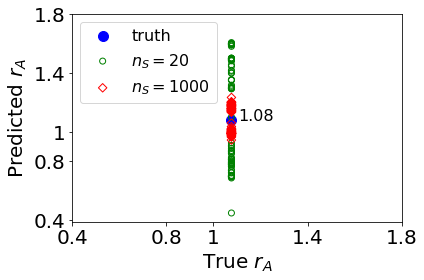

In [24]:
''' 
lower_error_20 = []
upper_error_20 = []
for i in range(np.sum(feasibility_20)):
    lower_error_20.append(true_test_revenue - lb_revenues_20[i])
    upper_error_20.append(ub_revenues_20[i]-true_test_revenue)
    

true_lst_20 = [true_test_revenue]*np.sum(feasibility_20)
true_lst_1000 = [true_test_revenue]*np.sum(feasibility_1000)


plt.scatter(true_test_revenue, true_test_revenue, marker='o', c='blue', s=100,label='truth')
# Annotate the point with the value
plt.text(true_test_revenue+0.18, true_test_revenue, f'{true_test_revenue:.2f}', fontsize=16, ha='right')


plt.scatter(true_lst_20, lb_revenues_20, marker='o', c='', edgecolors='g')
plt.scatter(true_lst_20, ub_revenues_20, marker='o', c='', edgecolors='g',label="$n_S = 20$")
plt.scatter(true_lst_1000, lb_revenues_1000, marker='D', c='', edgecolors='r')
plt.scatter(true_lst_1000, ub_revenues_1000, marker='D', c='', edgecolors='r',label="$n_S = 1000$")


x = [0.4,0.8,1,1.4,1.8]
plt.xticks(x,x)
y = [0.4,0.8,1,1.4,1.8]
plt.yticks(y,y)
plt.tick_params(labelsize=20)

#plt.ylim(lb-0.1,ub+0.1)
plt.legend(loc='upper left',fontsize=16)
plt.xlabel("True "+"$r_A$",fontsize=20)  
plt.ylabel("Predicted "+"$r_A$",fontsize=20) 
plt.tight_layout()
plt.savefig('sample_uncertainty.png')
plt.savefig('sample_uncertainty.pdf')
plt.show() '''

<ipython-input-28-ec76e9ecbc7e>:17: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(lb_revenues_20, true_lst_20, marker='o', c='', edgecolors='g')
<ipython-input-28-ec76e9ecbc7e>:18: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(ub_revenues_20, true_lst_20, marker='o', c='', edgecolors='g', label="$n_S = 20$")
<ipython-input-28-ec76e9ecbc7e>:19: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(lb_revenues_1000, true_lst_1000, marker='D', c='', edgecolors='r')
<ipython-input-28-ec76e9ecbc7e>:20: MatplotlibDeprecationWarn

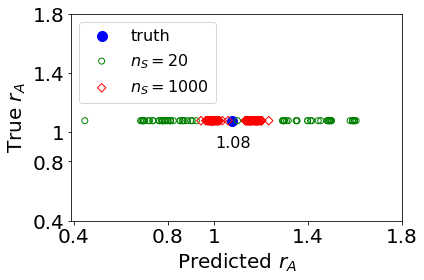

In [28]:
''' plotting the results for nS = 20 '''
''' lower_error_20 = []
upper_error_20 = []
for i in range(np.sum(feasibility_20)):
    lower_error_20.append(true_test_revenue - lb_revenues_20[i])
    upper_error_20.append(ub_revenues_20[i] - true_test_revenue)
    
# Create lists for the true test revenue points for plotting
true_lst_20 = [true_test_revenue] * np.sum(feasibility_20)
true_lst_1000 = [true_test_revenue] * np.sum(feasibility_1000)

# Swap x and y for transposing
plt.scatter(true_test_revenue, true_test_revenue, marker='o', c='blue', s=100, label='truth')
plt.text(true_test_revenue+0.08, true_test_revenue - 0.18, f'{true_test_revenue:.2f}', fontsize=16, ha='right')

# Swap lb and ub revenues to x-axis, true_lst to y-axis
plt.scatter(lb_revenues_20, true_lst_20, marker='o', c='', edgecolors='g')
plt.scatter(ub_revenues_20, true_lst_20, marker='o', c='', edgecolors='g', label="$n_S = 20$")
plt.scatter(lb_revenues_1000, true_lst_1000, marker='D', c='', edgecolors='r')
plt.scatter(ub_revenues_1000, true_lst_1000, marker='D', c='', edgecolors='r', label="$n_S = 1000$")

# Adjust the axis labels and ticks
x = [0.4, 0.8, 1, 1.4, 1.8]
plt.xticks(x, x)
y = [0.4, 0.8, 1, 1.4, 1.8]
plt.yticks(y, y)
plt.tick_params(labelsize=20)

plt.legend(loc='upper left', fontsize=16)
plt.xlabel("Predicted "+"$r_A$", fontsize=20)  # Now the predicted revenue on the x-axis
plt.ylabel("True "+"$r_A$", fontsize=20)  # Now the true revenue on the y-axis
plt.tight_layout()

# Save the plot
#plt.savefig('sample_uncertainty_transposed.png')
#plt.savefig('sample_uncertainty_transposed.pdf')

# Show the plot
plt.show() '''


<ipython-input-55-f8630d00c81c>:20: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(lb_revenues_20, [val + y_shift_20 for val in true_lst_20], marker='o', c='', edgecolors='g', label="$n_S = 20$ ")
<ipython-input-55-f8630d00c81c>:21: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(ub_revenues_20, [val + y_shift_20 for val in true_lst_20], marker='o', c='', edgecolors='g')
<ipython-input-55-f8630d00c81c>:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(lb_revenues_1000, [val + y_shift_1000 for val in true_lst_1000], ma

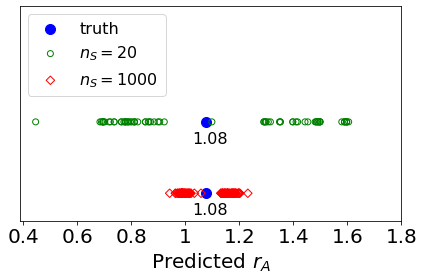

In [55]:
''' plotting the results for nS = 20 '''


# Create lists for the true test revenue points for plotting
true_lst_20 = [true_test_revenue] * np.sum(feasibility_20)
true_lst_1000 = [true_test_revenue] * np.sum(feasibility_1000)

# Keep the original shifts for the groups
y_shift_20 = 0.1  # Shift for nS = 20 (shifted upwards)
y_shift_1000 = -0.1  # Shift for nS = 1000 (shifted downwards)

# Plot the truth point, shifted along with each group
plt.scatter(true_test_revenue, true_test_revenue + y_shift_20, marker='o', c='blue', s=100, label='truth')
plt.text(true_test_revenue + 0.08, true_test_revenue + y_shift_20 - 0.06, f'{true_test_revenue:.2f}', fontsize=16, ha='right')

plt.scatter(true_test_revenue, true_test_revenue + y_shift_1000, marker='o', c='blue', s=100)
plt.text(true_test_revenue + 0.08, true_test_revenue + y_shift_1000 - 0.06, f'{true_test_revenue:.2f}', fontsize=16, ha='right')

# Plot the points for nS = 20, shifted slightly along the y-axis
plt.scatter(lb_revenues_20, [val + y_shift_20 for val in true_lst_20], marker='o', c='', edgecolors='g', label="$n_S = 20$ ")
plt.scatter(ub_revenues_20, [val + y_shift_20 for val in true_lst_20], marker='o', c='', edgecolors='g')

# Plot the points for nS = 1000, shifted slightly along the y-axis
plt.scatter(lb_revenues_1000, [val + y_shift_1000 for val in true_lst_1000], marker='D', c='', edgecolors='r', label="$n_S = 1000$ ")
plt.scatter(ub_revenues_1000, [val + y_shift_1000 for val in true_lst_1000], marker='D', c='', edgecolors='r')

# Adjust the axis labels and ticks
x = [0.4,0.6, 0.8, 1,1.2, 1.4,1.6, 1.8]
plt.xticks(x, x)
plt.tick_params(labelsize=20)

# Remove the y-axis ticks and labels but keep the space for layout purposes
plt.gca().set_yticks([])  # This removes the y-axis ticks
plt.gca().set_ylabel("")  # This removes the y-axis label

# Adjust the limits to add more space at the top and less space at the bottom
plt.ylim(0.9, 1.5)  # Smaller gap at the bottom, larger gap at the top

# Place the legend inside the plot at the upper left
plt.legend(loc='upper left', fontsize=16)

plt.xlabel("Predicted "+"$r_A$", fontsize=20)  # Now the predicted revenue on the x-axis

plt.tight_layout()

plt.savefig('sample_uncertainty.png')
plt.savefig('sample_uncertainty.pdf')

# Show the plot
plt.show()
